In [145]:
ls

Bc_epitopes_HLA_overlap-05-06-20.txt
HLA_freq_formated.txt
Select vaccine peptides.ipynb
Window_15mer-05-06-20.txt
Window_15mer-05-07-20.csv
Window_15mer-05-08-20.csv
Window_21mer-05-06-20.txt
Window_21mer-05-07-20.csv
Window_21mer-05-08-20.csv
Window_27mer-05-06-20.txt
Window_27mer-05-07-20.csv
Window_27mer-05-08-20.csv
selected-bcell-vaccine-15mer.csv
selected-bcell-vaccine-21mer.csv
selected-bcell-vaccine-27mer.csv
selected-tcell-vaccine-15mer.csv
selected-tcell-vaccine-21mer.csv
selected-tcell-vaccine-27mer.csv
vaccine-peptides-15mer-annotated-05-07-20.csv
vaccine-peptides-21mer-annotated-05-07-20.csv
vaccine-peptides-27mer-annotated-05-07-20.csv
vaccine-peptides-with-bcell-epitopes-and-manufacturability.csv


In [146]:
df_15mer = pd.read_csv("Window_15mer-05-08-20.csv")
df_21mer = pd.read_csv("Window_21mer-05-08-20.csv")
df_27mer = pd.read_csv("Window_27mer-05-08-20.csv")


In [147]:
extremely_unstable_dipeptides_unc = {
  "DG",
  "NG",
}
problematic_dipeptides_unc = {
   "DS", 
   "DN", 
   "DD", 
   "NN", 
   "ND", 
   "NS",
}

problematic_dipeptides_jpt = {"NP"}

problematic_dipeptides = problematic_dipeptides_unc.union(problematic_dipeptides_jpt)

In [148]:
hydropathy_dict = {
    "A": 1.8,
    "C": 2.5,
    "D": -3.5,
    "E": -3.5,
    "F": 2.8,
    "G": -0.4,
    "H": -3.2,
    "I": 4.5,
    "K": -3.9,
    "L": 3.8,
    "M": 1.9,
    "N": -3.5,
    "P": -1.6,
    "Q": -3.5,
    "R": -4.5,
    "S": -0.8,
    "T": -0.7,
    "V": 4.2,
    "W": -0.9,
    "Y": -1.3
}

In [149]:

def gravy_score(amino_acids):
    """
    Mean amino acid hydropathy averaged across residues of a peptide
    or protein sequence.
    """
    total = 0 
    for aa in amino_acids:
        total += hydropathy_dict[aa]
    return total / len(amino_acids)


In [150]:

def max_kmer_gravy_score(amino_acids, k):
    """
    Returns max GRAVY score of any kmer in the amino acid sequence,
    used to determine if there are any extremely hydrophobic regions within a
    longer amino acid sequence.
    """
    return max(
        gravy_score(amino_acids[i:i + k])
        for i in range(len(amino_acids) - k + 1))


In [151]:
def max_short_subsequence_gravy_score(amino_acids):
    gravy_scores = [
        max_kmer_gravy_score(amino_acids, k)
        for k in [5, 6, 7, 8]
    ]
    return max(gravy_scores)


In [152]:


def difficult_c_terminal(amino_acids):
    return amino_acids[-1] in {"P", "C", "H"}

def difficult_n_terminal(amino_acids):
    """
    Is the N-terminus one of {Gln, Glu, Cys}?
    ---
    Priority I: avoid N-terminal Gln, Glu, Cys
    Priority II: Asparagine at the N-terminus of a peptide is also hard
    to synthesize, though not as bad as {Gln, Glu, Cys}
    """
    return amino_acids[0] in {"Q", "E", "C", "N"}


def cysteine_count(amino_acids):
    """
    How many cysteines are in the amino acid sequence?
    Problem with cysteine residues: They can form disulfide bonds across
    distant parts of the peptide
    """
    return amino_acids.count("C")

def methionine_count(amino_acids):
    """
    How many methionies?
    """
    return amino_acids.count("M")

def thiol_count(amino_acids):
    return cysteine_count(amino_acids) + methionine_count(amino_acids)

def num_extremely_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in extremely_unstable_dipeptides_unc:
        total += amino_acids.count(dipeptide)
    return total
    extremely_unstable_dipeptides_unc

def num_moderately_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in problematic_dipeptides_unc.union(problematic_dipeptides_jpt):
        total += amino_acids.count(dipeptide)
    return total

In [153]:
def annotate_manufacturability(df):
    df = df.copy()
    df["num_extremely_unstable_dipeptides"] = df.Sequence.map(num_extremely_unstable_dipeptides)
    df["num_moderately_unstable_dipeptides"] = df.Sequence.map(num_moderately_unstable_dipeptides)
    df["num_cysteines"] = df.Sequence.map(cysteine_count)
    df["num_methionines"] = df.Sequence.map(methionine_count)
    df["num_thiols"] = df.Sequence.map(thiol_count)
    df["difficult_c_terminal"] = df.Sequence.map(difficult_c_terminal)
    df["difficult_n_terminal"] = df.Sequence.map(difficult_n_terminal)
    df["gravy"] = df.Sequence.map(gravy_score)
    df["max_kmer_gravy"] = df.Sequence.map(max_short_subsequence_gravy_score)
    df["extreme_local_hydrophobicity"] = df.max_kmer_gravy > 2.5
    df["difficult_local_hydrophobicity"] = df.max_kmer_gravy > 1.5
    df["too_many_cysteines"] = df.num_cysteines > 1
    df["manufacturability_difficulty_score"] = (
        1.0  * (df.gravy > 2.0) +        # hydrophobicity of whole peptide
        1.0 * df.difficult_n_terminal +  # lowest priority: N-terminal residues
        2.0 * df.difficult_c_terminal + 
        2.0 * df.num_thiols + 
        2.0 * df.difficult_local_hydrophobicity + 
        3.0 * df.num_moderately_unstable_dipeptides + 
        5.0 * df.too_many_cysteines +          # disulfide bonds
        10.0 * df.extreme_local_hydrophobicity + 
        10.0 * df.num_extremely_unstable_dipeptides 
    )
    return df

df_27mer_annot = annotate_manufacturability(df_27mer);
df_27mer_annot.to_csv("vaccine-peptides-27mer-annotated-05-07-20.csv", index=False)
df_21mer_annot = annotate_manufacturability(df_21mer);
df_21mer_annot.to_csv("vaccine-peptides-21mer-annotated-05-07-20.csv", index=False)
df_15mer_annot = annotate_manufacturability(df_15mer)
df_15mer_annot.to_csv("vaccine-peptides-15mer-annotated-05-07-20.csv", index=False)




In [154]:
df_concat = pd.concat([
    df_15mer_annot,
    df_21mer_annot,
    df_27mer_annot,
])
df_concat["Length"] = df_concat.Sequence.str.len()

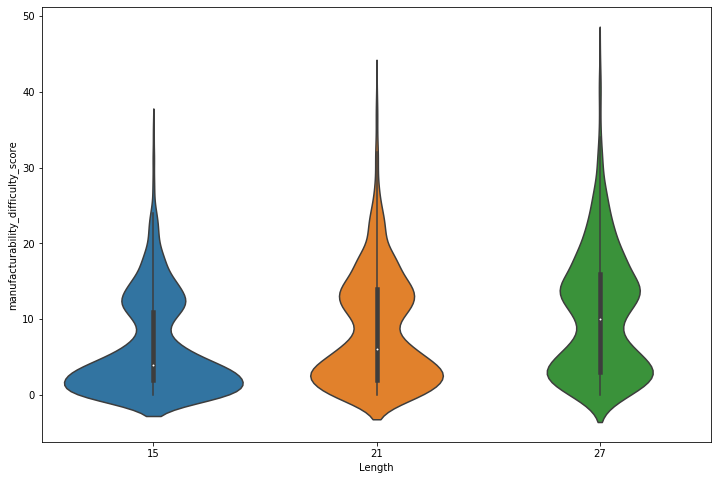

In [155]:
import seaborn 
import matplotlib 
from matplotlib import pyplot
fig = pyplot.figure(figsize=(12,8))

seaborn.violinplot(data=df_concat, x="Length", y="manufacturability_difficulty_score")

In [156]:
bcell_epitopes = pd.read_csv("../bcell/accessible-linear-bcell-epitopes-grouped-merged-filtered.csv", index_col=0)

In [157]:
bcell_epitopes

,num_sources,sources,accessible_subsequence_start,accessible_subsequence_end,accessible_subsequence,accessible_subsequence_length,accessible_subsequence_is_4mer_or_longer,IgG,IgA,IgG_and_IgA,accessible_subsequence_contains_polymorphism,accessible_subsequence_contains_glycosite,near_any_feature,in_any_feature
9,3,Wang 2020 S456-460; Dahlke 2020 S449-463; Char...,457,473,RKSNLKPFERDISTEIY,17,True,True,True,True,False,False,True,True
12,4,Charite 2020 S569-583; Charite 2020 S571-585; ...,580,583,QTLE,4,True,True,True,True,False,False,True,False
17,6,Poh 2020 S809-826; Wang 2020 S806-820; Charite...,809,812,PSKP,4,True,True,True,True,False,False,True,False
21,2,Dahlke 2020 S1131-1145; Charite 2020 S1141-1155,1142,1146,QPELD,5,True,True,True,True,False,False,True,False


In [158]:

from collections import OrderedDict

def annotate_overlapping_bcell_epitopes(df, bcell_epitopes):
    cols = OrderedDict([
        ("overlapping_bcell_epitope", []),
        ("overlapping_bcell_epitope_start", []),
        ("overlapping_bcell_epitope_end", []),
        ("overlapping_bcell_epitope_length", []),
        ("fraction_of_full_bcell_epitope", []),
        ("full_bcell_epitope", []),
    ])

    for (prot, start, end) in zip(df_concat.Protein, df_concat.Start, df_concat.End):
        found_bcell_epitope = False
        if prot == "S":
            for (epitope, epitope_start, epitope_end) in zip(
                    bcell_epitopes.accessible_subsequence,
                    bcell_epitopes.accessible_subsequence_start,
                    bcell_epitopes.accessible_subsequence_end):
                if end >= epitope_start and start <= epitope_end:
                    found_bcell_epitope = True
                    overlap_start = max(epitope_start, start)
                    overlap_end = min(epitope_end, end)
                    overlap_length = overlap_end - overlap_start + 1
                    overlapping_bcell_epitope = epitope[
                        overlap_start - epitope_start:
                        overlap_end - epitope_start + 1]
                    overlap_percent_of_full_bcell_epitope = overlap_length / len(epitope)

                    cols["overlapping_bcell_epitope"].append(overlapping_bcell_epitope)
                    cols["overlapping_bcell_epitope_start"].append(overlap_start)
                    cols["overlapping_bcell_epitope_end"].append(overlap_end)
                    cols["overlapping_bcell_epitope_length"].append(overlap_length)
                    cols["fraction_of_full_bcell_epitope"].append(overlap_percent_of_full_bcell_epitope)
                    cols["full_bcell_epitope"].append(epitope)
                    break
        if not found_bcell_epitope:
            cols["overlapping_bcell_epitope"].append(None)
            cols["overlapping_bcell_epitope_start"].append(None)
            cols["overlapping_bcell_epitope_end"].append(None)
            cols["overlapping_bcell_epitope_length"].append(0)
            cols["fraction_of_full_bcell_epitope"].append(0.0)
            cols["full_bcell_epitope"].append(None)
        
    df_with_bcell_epitopes = df.copy()
    for (col_name, col_values) in cols.items():
        df_with_bcell_epitopes[col_name] = col_values
    return df_with_bcell_epitopes

df_with_bcell_epitopes = annotate_overlapping_bcell_epitopes(df_concat, bcell_epitopes);
df_with_bcell_epitopes

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,difficult_local_hydrophobicity,too_many_cysteines,manufacturability_difficulty_score,Length,overlapping_bcell_epitope,overlapping_bcell_epitope_start,overlapping_bcell_epitope_end,overlapping_bcell_epitope_length,fraction_of_full_bcell_epitope,full_bcell_epitope
0,MFVFLVLLPLVSSQC,S,1,15,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,19.0,15,None,NaN,NaN,0,0.0,None
1,FVFLVLLPLVSSQCV,S,2,16,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,15.0,15,None,NaN,NaN,0,0.0,None
2,VFLVLLPLVSSQCVN,S,3,17,NaN,NaN,0.0,VFLVLLPLVSSQCVN,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
3,FLVLLPLVSSQCVNL,S,4,18,NaN,NaN,0.0,FLVLLPLVSSQCVNL,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
4,LVLLPLVSSQCVNLT,S,5,19,NaN,NaN,0.0,LVLLPLVSSQCVNLT,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,DSTQAMGYINVFAFPFTIYSLLLCRMN,N,415,441,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1910,STQAMGYINVFAFPFTIYSLLLCRMNS,N,416,442,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1911,TQAMGYINVFAFPFTIYSLLLCRMNSR,N,417,443,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1912,QAMGYINVFAFPFTIYSLLLCRMNSRN,N,418,444,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,22.0,27,None,NaN,NaN,0,0.0,None


In [164]:
print(df_concat.columns)

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length'],
      dtype='object')


In [183]:
def annotate_selection_criteria(df, rounding_decimals=2):
    df = df.copy()
    df["manufacturability_feasibility_score"] = 2.0 ** (
        -df.manufacturability_difficulty_score / 10.0)
    df["has mouse MHC-I b"] = ~df["Mouse MHC-I b"].isnull()
    df["has mouse MHC-II b"] = ~df["Mouse MHC-II b"].isnull()
    df["has mouse MHC-I d"] = ~df["Mouse MHC-I d"].isnull()
    df["has mouse MHC-II d"] = ~df["Mouse MHC-II d"].isnull()
    df["mouse H2-b count"] = (
        df["has mouse MHC-I b"].astype(int) + 
        df["has mouse MHC-II b"].astype(int) 
    )
    df["mouse H2-d count"] = (
        df["has mouse MHC-I d"].astype(int) + 
        df["has mouse MHC-II d"].astype(int) 
    )
    df["mouse class I count"] = (
        df["has mouse MHC-I b"].astype(int) + 
        df["has mouse MHC-I d"].astype(int) 
    )
    df["mouse class II count"] = (
        df["has mouse MHC-II b"].astype(int) + 
        df["has mouse MHC-II d"].astype(int) 
    )
    df["mouse count"] = df["mouse H2-b count"] + df["mouse H2-d count"]
    df["HLA-I_pop_freq_rounded"] = df["HLA-I_pop_freq"].round(rounding_decimals)
    df["HLA-II_pop_freq_rounded"] = df["HLA-II_pop_freq"].round(rounding_decimals)
    df["Total_frequency_rounded"] = df["Total_frequency"].round(rounding_decimals)
    df["manufacturability_feasibility_score_rounded"] = \
        df["manufacturability_feasibility_score"].round(rounding_decimals)
    return df



In [301]:
def parse_alleles(alleles):
    if type(alleles) in (list, set, tuple):
        alleles = set(alleles)
    elif type(alleles) is str:
        alleles = set(alleles.split(","))
    else:
        alleles = set()
    return alleles

    
def population_coverage(alleles, allele_frequencies):
    alleles = parse_alleles(alleles)

    if len(alleles) > 0:

        individual_allele_frequencies = np.array([allele_frequencies[a] for a in alleles])
        prob_not_allele_haploid = 1.0 - (individual_allele_frequencies / 100.0)
        prob_not_allele_diploid = prob_not_allele_haploid ** 2
        prob_missing_all = np.prod(prob_not_allele_diploid)
        prob_atleast_one = 1.0 - prob_missing_all

        return prob_atleast_one
    else:
        return 0.0 

def update_marginal_coverage(
        df, 
        allele_frequencies, 
        chosen_class1_alleles=[], 
        chosen_class2_alleles=[], 
        decimals=2,
        prefix="marginal_"):
    """
    Create or update columns named 'marginal_class1_coverage' & 'marginal_class2_coverage'
    by excluding a blacklist of class1 & class2 alleles which have already been 
    included in a partially constructed list of vaccine peptides.
    
    Expects allele_frequencies to be a dictionary with values between [0, 100]
    and will update DataFrame with values in the same range. 
    """
    # based on which class1 and class2 alleles we've already chosen
    # compute updated 
    df = df.copy()
    chosen_class1_alleles = set(chosen_class1_alleles)
    chosne_class2_alleles = set(chosen_class2_alleles)
    class1_coverages = []
    class2_coverages = []
    for class1_alleles, class2_alleles in zip(df['HLA-I_haplotypes'], df['HLA-II_haplotypes']):
        class1_alleles = parse_alleles(class1_alleles)
        class2_alleles = parse_alleles(class2_alleles)
        extra_class1_alleles = class1_alleles.difference(chosen_class1_alleles)
        extra_class2_alleles = class2_alleles.difference(chosen_class2_alleles)
        class1_coverages.append(population_coverage(extra_class1_alleles, allele_frequencies))
        class2_coverages.append(population_coverage(extra_class2_alleles, allele_frequencies))
    
    class1_key = "%sclass1_coverage" % prefix
    df[class1_key] = class1_coverages
    df[class1_key + "_rounded"] = df[class1_key].round(decimals)
    class2_key = "%sclass2_coverage" % prefix
    df[class2_key] = class2_coverages
    df[class2_key + "_rounded"] = df[class2_key].round(decimals)
    combined_key = "%scombined_coverage" % prefix
    df[combined_key] = np.array(class1_coverages) * np.array(class2_coverages)
    df[combined_key + "_rounded"] = df[combined_key].round(decimals)
    return df

In [302]:
df_concat_with_marginal_freqs = update_marginal_coverage(
    df=df_concat,
    allele_frequencies=allele_to_frequency)
# sanity check that the population frequency calculation matches the one 
# that Christof annotated vaccine peptides with in the absence of any 
# "chosen" / excluded alleles.
print(
    "Should be near zero",
    (df_concat_with_marginal_freqs["HLA-I_pop_freq"] - df_concat_with_marginal_freqs["marginal_class1_coverage"]).abs().max(),
    (df_concat_with_marginal_freqs["HLA-II_pop_freq"] - df_concat_with_marginal_freqs["marginal_class2_coverage"]).abs().max()
)
df_concat_with_marginal_freqs_a0201 = update_marginal_coverage(
    df=df_concat,
    chosen_class1_alleles={"HLA-A*02:01"},
    allele_frequencies=allele_to_frequency)
# sanity check that the population frequency calculation matches the one 
# that Christof annotated vaccine peptides with in the absence of any 
# "chosen" / excluded alleles.
print(
    "Should be >0.4",
    (df_concat_with_marginal_freqs["HLA-I_pop_freq"] - df_concat_with_marginal_freqs_a0201["marginal_class1_coverage"]).abs().max(),
    (df_concat_with_marginal_freqs["HLA-II_pop_freq"] - df_concat_with_marginal_freqs_a0201["marginal_class2_coverage"]).abs().max()
)


Should be near zero 7.771561172376096e-16 6.661338147750939e-16
Should be >0.4 0.41749339987056 6.661338147750939e-16


In [303]:
df_freq = pd.read_csv("HLA_freq_formated.txt");
df_freq["Class"] = df_freq.Haplotype.map(lambda x: "II" if "D" in x else "I");
print(df_freq.groupby("Class")["Frequency"].sum())

allele_to_frequency = {a: f for (a, f) in zip(df_freq["Haplotype"], df_freq["Frequency"])}
unique_alleles_in_vaccine_peptides = set([])
for class1, class2 in zip(df_concat["HLA-I_haplotypes"], df_concat["HLA-II_haplotypes"]):
    if type(class1) is str:
        unique_alleles_in_vaccine_peptides.update(class1.split(","))
    if type(class2) is str:
        unique_alleles_in_vaccine_peptides.update(class2.split(","))
len(unique_alleles_in_vaccine_peptides), len(allele_to_frequency)
print("Alleles in frequency table, not in vaccine peptides:")
for a, f in allele_to_frequency.items():
    if a not in unique_alleles_in_vaccine_peptides:
        print("==> %s (%0.2f)" % (a, f))
print("Alleles in vaccine peptides, not in frequency table:")
for a in unique_alleles_in_vaccine_peptides:
    if a not in allele_to_frequency:
        print("==> %s" % a)

Class
I     164.655275
II    139.423328
Name: Frequency, dtype: float64
Alleles in frequency table, not in vaccine peptides:
==> HLA-DQA1*03:01/DQB1*03:02 (9.62)
==> HLA-DQA1*01:01/DQB1*05:01 (10.85)
==> HLA-DQA1*02:01/DQB1*02:02 (11.08)
==> HLA-DQA1*01:03/DQB1*06:03 (5.66)
==> HLA-B*15:01 (4.02)
Alleles in vaccine peptides, not in frequency table:


In [304]:


def select_bcell_vaccine_peptides(df):
    df = annotate_selection_criteria(df)
    
    sort_columns = [
        "fraction_of_full_bcell_epitope",
        "HLA-II_pop_freq_rounded",
        "mouse class II count",
        "manufacturability_feasibility_score_rounded",
        "HLA-I_pop_freq_rounded",
        "mouse class I count",
    ]

    selected_peptides = set()
    dataframes = []
    for length, df_length in df.groupby("Length"):
        for epitope, df_epitope in df_length.groupby("full_bcell_epitope"):
            df_sorted = df_epitope.sort_values(by=sort_columns, ascending=False)
            
            selected_peptides.add(df_sorted.Sequence.iloc[0])
            dataframes.append(df_sorted.iloc[:1])
            
            has_class2_h2b = ~df_sorted['Mouse MHC-II b'].isnull()
            has_class2_h2d = ~df_sorted['Mouse MHC-II d'].isnull()
            has_both = has_class2_h2b & has_class2_h2d
            
            both = df_sorted[has_both]
            if len(both) > 0 and both.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(both.Sequence.iloc[0])
                dataframes.append(both.iloc[:1])
            
            h2b = df_sorted[has_class2_h2b]
            if len(h2b) > 0 and h2b.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2b.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
            
            h2d = df_sorted[has_class2_h2d]
            if len(h2d) > 0 and h2d.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2d.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
    return pd.concat(dataframes).sort_values(["Length", "Protein", "Start"])


In [305]:
df_selected_bcell_vaccine_peptides = select_bcell_vaccine_peptides(df_with_bcell_epitopes)
for length, df_length in df_selected_bcell_vaccine_peptides.groupby("Length"):
    df_length.to_csv("selected-bcell-vaccine-%dmer.csv" % length, index=False)
df_selected_bcell_vaccine_peptides

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,has mouse MHC-II d,mouse H2-b count,mouse H2-d count,mouse class I count,mouse class II count,mouse count,HLA-I_pop_freq_rounded,HLA-II_pop_freq_rounded,Total_frequency_rounded,manufacturability_feasibility_score_rounded
457,KSNLKPFERDISTEI,S,458,472,"KPFERDISTEI,KSNLKPFER","HLA-B*07:02,HLA-A*11:01",0.286880,NaN,NaN,0.000000,...,False,0,0,0,0,0,0.29,0.00,0.00,1.00
467,ISTEIYQAGSTPCNG,S,468,482,NaN,NaN,0.000000,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,False,1,0,0,1,1,0.00,0.21,0.00,0.44
568,IADTTDAVRDPQTLE,S,569,583,NaN,NaN,0.000000,NaN,NaN,0.000000,...,False,0,0,0,0,0,0.00,0.00,0.00,1.00
798,GFNFSQILPDPSKPS,S,799,813,NaN,NaN,0.000000,GFNFSQILPDPSKPS,"HLA-DRB1*01:01,HLA-DRB1*04:01",0.233805,...,False,1,0,0,1,1,0.00,0.23,0.00,1.00
1131,IVNNTVYDPLQPELD,S,1132,1146,VYDPLQPEL,HLA-C*04:01,0.231730,NaN,NaN,0.000000,...,False,0,1,1,0,1,0.23,0.00,0.00,0.81
452,YRLFRKSNLKPFERDISTEIY,S,453,473,"FRKSNLKPF,KPFERDISTEI,KSNLKPFER,RLFRKSNL,RLFRK...","HLA-C*07:02,HLA-B*07:02,HLA-A*11:01,HLA-B*08:0...",0.780469,YRLFRKSNLKPFERD,HLA-DRB1*07:01,0.226271,...,False,1,0,1,0,1,0.78,0.23,0.18,1.00
461,KPFERDISTEIYQAGSTPCNG,S,462,482,KPFERDISTEI,HLA-B*07:02,0.200499,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,False,1,0,0,1,1,0.20,0.21,0.04,0.44
579,QTLEILDITPCSFGGVSVITP,S,580,600,ILDITPCSF,HLA-C*05:01,0.133120,DITPCSFGGVSVITP,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,False,0,0,0,0,0,0.13,0.21,0.03,0.62
793,IKDFGGFNFSQILPDPSKPSK,S,794,814,ILPDPSKPSK,HLA-A*03:01,0.214307,"FGGFNFSQILPDPSK,FNFSQILPDPSKPSK,GFNFSQILPDPSKP...","HLA-DRB1*04:01,HLA-DRB1*01:01",0.233805,...,False,1,0,0,1,1,0.21,0.23,0.05,1.00
1125,CDVVIGIVNNTVYDPLQPELD,S,1126,1146,VYDPLQPEL,HLA-C*04:01,0.231730,"CDVVIGIVNNTVYDP,DVVIGIVNNTVYDPL",HLA-DRB1*01:01,0.130464,...,False,0,1,1,0,1,0.23,0.13,0.03,0.29


In [306]:
df_with_bcell_epitopes.columns

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length',
       'overlapping_bcell_epitope', 'overlapping_bcell_epitope_start',
       'overlapping_bcell_epitope_end', 'overlapping_bcell_epitope_length',
       'fraction_of_full_bcell_epitope', 'full_bcell_epitope'],
      dtype='object')

In [307]:
len(df_concat)

5742

In [317]:
from collections import Counter

def select_tcell_vaccine_peptides(
        df, 
        length=None,
        class1=True,
        class2=True,
        H2b=True,
        H2d=True,
        min_population_coverage=0.9,
        min_per_protein={"S": 1, "M": 1, "N": 1},
        max_kmer_overlap=8):
    
    df = annotate_selection_criteria(df)
    
    if class1 and class2:
        primary_sort_columns = ["marginal_combined_coverage_rounded", "mouse count"]
        secondary_sort_columns = [
            "marginal_class1_coverage_rounded", 
            "marginal_class2_coverage_rounded", 
            "mouse class I count",
            "mouse class II count"
        ]
    elif class1:
        primary_sort_columns = ["marginal_class1_coverage_rounded", "mouse class I count"]
        secondary_sort_columns = ["marginal_class2_coverage_rounded", "mouse class II count"]
    elif class2:
        primary_sort_columns = ["marginal_class2_coverage_rounded", "mouse class II count"]
        secondary_sort_columns = ["marginal_class1_coverage_rounded", "mouse class I count"]
    else:
        raise ValueError(
            "Either class1 or class2 must be True")
    
    sort_columns = (
        primary_sort_columns + 
        ["manufacturability_feasibility_score_rounded"] + 
        secondary_sort_columns
    )
    
    masks = []
    
    if H2b:
        if class1:
            H2b_class1 = df["has mouse MHC-I b"]
            print("%d/%d peptides have class I H2b" % (H2b_class1.sum(), len(df)))
            masks.append(H2b_class1)
        if class2:
            H2b_class2 = df["has mouse MHC-II b"]
            print("%d/%d peptides have class II H2b" % (H2b_class2.sum(), len(df)))
            masks.append(H2b_class2)
    if H2d:
        if class1:
            H2d_class1 = df["has mouse MHC-I d"]
            print("%d/%d peptides have class I H2d" % (H2d_class1.sum(), len(df)))
            masks.append(H2d_class1)
        if class2:
            H2d_class2 = df["has mouse MHC-II d"]
            print("%d/%d peptides have class II H2d" % (H2d_class2.sum(), len(df)))
            masks.append(H2d_class2)
            
    if length:
        length_mask = df.Sequence.str.len() == length
        print("%d/%d peptides are %dmer" % (length_mask.sum(), len(df), length))
        masks.append(length_mask)
    
    combined_mask = np.ones(len(df), dtype=bool)
    for m in masks:
        combined_mask = combined_mask & m.values
    df_subset = df[combined_mask]
    print("Keeping %d/%d peptides" % (len(df_subset), len(df)))
    
    k = max_kmer_overlap + 1

    
    class1_population_coverage = 0.0
    class2_population_coverage = 0.0
    
    dataframes = []
    n_selected = 0
    seen_kmers = set()
    protein_counts = Counter()
 
    chosen_class1_alleles = set()
    chosen_class2_alleles = set()
    need_more_class1 = class1
    need_more_class2 = class2
    while need_more_class1 or need_more_class2:
        df_with_marginal_coverage = update_marginal_coverage(
            df=df_subset,
            allele_frequencies=allele_to_frequency, 
            chosen_class1_alleles=chosen_class1_alleles, 
            chosen_class2_alleles=chosen_class2_alleles)
        
        df_sorted = df_with_marginal_coverage.sort_values(sort_columns, ascending=False)
        
        added_peptide = False

        for i in range(len(df_sorted)):
            peptide = df_sorted.Sequence.iloc[i]
            peptide_kmers = {
                peptide[peptide_start:peptide_start + k]
                for peptide_start in range(len(peptide) - k + 1)
            }
            already_seen_sequence = any([
                kmer in seen_kmers for kmer in peptide_kmers
            ])
            if already_seen_sequence:
                continue
                

            marginal_class1_coverage = df_sorted.marginal_class1_coverage.iloc[i]
            marginal_class2_coverage = df_sorted.marginal_class2_coverage.iloc[i]
            
            if need_more_class1 and need_more_class2 and max(marginal_class1_coverage, marginal_class2_coverage) == 0:
                # not attaining either objective by adding this peptide, so skip it
                continue
            elif need_more_class1 and marginal_class1_coverage == 0:
                continue
            elif need_more_class2 and marginal_class2_coverage == 0:
                continue
            
            # accept peptide 
            added_peptide = True
            seen_kmers.update(peptide_kmers)
            n_selected += 1
            protein_counts[df_sorted.Protein.iloc[i]] += 1
            dataframes.append(df_sorted[i:i+1])
            
            class1_alleles = parse_alleles(df_sorted["HLA-I_haplotypes"].iloc[i])
            chosen_class1_alleles.update(class1_alleles)
            
            class2_alleles = parse_alleles(df_sorted["HLA-II_haplotypes"].iloc[i])
            chosen_class2_alleles.update(class2_alleles)
            break
        
               
        class1_population_coverage = population_coverage(
            chosen_class1_alleles,
            allele_frequencies=allele_to_frequency)
        class2_population_coverage = population_coverage(
            chosen_class2_alleles,
            allele_frequencies=allele_to_frequency)
                
        if added_peptide:
            print("==> Selected %d peptides, covering %0.2f%% of Class I (%d alleles) and %0.2f%% of Class II (%d alleles)" % (
                len(dataframes),
                class1_population_coverage * 100,
                len(chosen_class1_alleles),
                class2_population_coverage * 100,
                len(chosen_class2_alleles),
            ))
            need_more_class1 = class1 and class1_population_coverage < min_population_coverage
            need_more_class2 = class2 and class2_population_coverage < min_population_coverage
        else:
            print(
                "Unable to achieve target population coverage of %0.2f, current class1=%0.2f, class2=%0.2f" % (
                    min_population_coverage,
                    class1_population_coverage,
                    class2_population_coverage))
            need_more_class1 = need_more_class2 = False
    print("Protein counts: %s" % (dict(protein_counts.items()),))
    df_result = pd.concat(dataframes).sort_values(["Length", "Protein", "Start"])
    return df_result

In [323]:
i = 0
for class1 in [False, True]:
    for class2 in [False, True]:
        if not (class1 or class2):
            continue
        for h2b in [False, True]:
            for h2d in [False, True]:
                for length in df_concat.Length.unique():
                    print("\n%d) Class1=%s, Class2=%s, H2b=%s, H2d=%s, Length=%d" % (
                        i + 1,
                        class1, 
                        class2, 
                        h2b, 
                        h2d, 
                        length))
                    i += 1
                    df_tcell_vaccine_peptides = \
                        select_tcell_vaccine_peptides(
                            df_with_bcell_epitopes,
                            class1=class1,
                            class2=class2,
                            H2b=h2b,
                            H2d=h2d,
                            length=length)



1) Class1=False, Class2=True, H2b=False, H2d=False, Length=15
1914/5742 peptides are 15mer
Keeping 1914/5742 peptides
==> Selected 1 peptides, covering 29.58% of Class I (3 alleles) and 78.56% of Class II (8 alleles)
==> Selected 2 peptides, covering 83.95% of Class I (10 alleles) and 84.69% of Class II (10 alleles)
==> Selected 3 peptides, covering 87.17% of Class I (11 alleles) and 88.45% of Class II (11 alleles)
Unable to achieve target population coverage of 0.90, current class1=0.87, class2=0.88
Protein counts: {'S': 2, 'M': 1}

2) Class1=False, Class2=True, H2b=False, H2d=False, Length=21
1914/5742 peptides are 21mer
Keeping 1914/5742 peptides
==> Selected 1 peptides, covering 29.58% of Class I (3 alleles) and 80.92% of Class II (9 alleles)
==> Selected 2 peptides, covering 51.79% of Class I (5 alleles) and 88.45% of Class II (11 alleles)
Unable to achieve target population coverage of 0.90, current class1=0.52, class2=0.88
Protein counts: {'S': 2}

3) Class1=False, Class2=True,

1325/5742 peptides have class I H2b
1914/5742 peptides are 27mer
Keeping 611/5742 peptides
==> Selected 1 peptides, covering 91.04% of Class I (10 alleles) and 72.78% of Class II (6 alleles)
Protein counts: {'S': 1}

22) Class1=True, Class2=False, H2b=True, H2d=True, Length=15
1325/5742 peptides have class I H2b
1218/5742 peptides have class I H2d
1914/5742 peptides are 15mer
Keeping 132/5742 peptides
==> Selected 1 peptides, covering 81.06% of Class I (6 alleles) and 0.00% of Class II (0 alleles)
==> Selected 2 peptides, covering 88.98% of Class I (9 alleles) and 46.49% of Class II (3 alleles)
==> Selected 3 peptides, covering 92.28% of Class I (11 alleles) and 57.43% of Class II (5 alleles)
Protein counts: {'M': 2, 'S': 1}

23) Class1=True, Class2=False, H2b=True, H2d=True, Length=21
1325/5742 peptides have class I H2b
1218/5742 peptides have class I H2d
1914/5742 peptides are 21mer
Keeping 236/5742 peptides
==> Selected 1 peptides, covering 91.04% of Class I (10 alleles) and 51.32% 

In [257]:
sum([allele_to_frequency[a] for a in c1s])

62.756035999999995